#Format Data for Experiment in ABM environment

In [1]:
#Import Packages
#Needed for moving to output
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as pl
import itertools
from collections import Counter

In [2]:
from google.cloud import storage
from io import BytesIO
client = storage.Client()
bucket_name = "tcell_tumor_1"
file_name = "df_ABM_import_2HCTcell_exp_no_other.csv"
bucket = client.get_bucket(bucket_name)
blob = bucket.get_blob(file_name)
content = blob.download_as_string()
df = pd.read_csv(BytesIO(content), index_col=0)
df

,AbsoluteY,AbsoluteX,H2Db,H2Kb,PD1,PDL1,Region,Cell Type,IFNg
3416,17.420858,39.383058,7439.972930,14291.879749,1765.165893,37624.272605,2HCTcell_d3,PDL1p,0
3462,17.701583,48.443346,4321.991455,5538.288774,1967.220797,15787.306125,2HCTcell_d3,PDL1p,0
3464,17.415336,11.621325,5690.707305,8733.550956,2934.491795,21794.349526,2HCTcell_d3,PDL1p,0
3474,116.736335,56.197847,4882.764345,13602.709731,3341.373360,28624.012461,2HCTcell_d3,PDL1p,0
3478,99.554303,14.165983,4688.975777,15945.410596,2197.945326,19190.868573,2HCTcell_d3,PDL1p,0
...,...,...,...,...,...,...,...,...,...
17636,28.411844,41.846260,13985.433737,41314.542279,6279.721097,37080.194910,2HCTcell_d3,PD1n,0
17640,85.217626,18.389745,11528.709624,25363.626005,13704.653409,23124.886773,2HCTcell_d3,PD1n,0
17642,162.779854,147.480997,9087.268135,34835.322826,7723.293285,29137.886824,2HCTcell_d3,PD1n,0
17643,164.355964,198.745266,4670.813447,31052.547392,3183.370010,11234.107822,2HCTcell_d3,PD1n,0


In [4]:
#Install tumor-tcell
!pip install tumor-tcell==0.0.21
#!pip install vivarium-core==0.2.0
#!pip install vivarium-multibody

  Created wheel for tumor-tcell: filename=tumor_tcell-0.0.21-py3-none-any.whl size=39811 sha256=1babf6a9002f514abcda06dd8b3e5fd37ae5269f9aa1e2d38126fb83ea3a9512
  Stored in directory: /home/jupyter/.cache/pip/wheels/ec/5c/d2/9b1a4f5ebffee36d5ea36273d7073d1dae4e855898ff01f484
Successfully built tumor-tcell
  Attempting uninstall: tumor-tcell
    Found existing installation: tumor-tcell 0.0.20
    Uninstalling tumor-tcell-0.0.20:
      Successfully uninstalled tumor-tcell-0.0.20


In [5]:
from vivarium.library.units import units, remove_units
from tumor_tcell.experiments.main import tumor_tcell_abm
from tumor_tcell.experiments.main import plots_suite
from tumor_tcell.experiments.main import get_tcells
from tumor_tcell.experiments.main import get_tumors
from tumor_tcell.library.phylogeny import get_phylogeny

In [6]:
#Get bounds
min_2HC_x = 0
max_2HC_x = 200
min_2HC_y = 0
max_2HC_y = 200

ybounds = max_2HC_y - min_2HC_y
xbounds = max_2HC_x - min_2HC_x
bounds = [xbounds,ybounds]

In [7]:
df_2HC_exp = df.copy()

In [8]:
#Import from Jupyter notebook
df_2HC_exp1 = df_2HC_exp.copy()

#Column Number for iloc iterating
Ypos = 0
Xpos = 1
H2Kb = 3
PD1 = 4
PDL1 = 5
Celltype = 7
IFNg_con = 8 

tumor_diameter = 15
tcell_diameter = 7.5

tumors = {}
IFNg = {}
tcells = {}

for i in range(len(df_2HC_exp1)):
  if df_2HC_exp1.iloc[i, Celltype] == 'PDL1p' or df_2HC_exp1.iloc[i, Celltype] == 'PDL1n':
    tumors.update({
        'tumor_'+ str(df_2HC_exp1.index[i]) : {
            'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
            'type': 'tumor',
            'cell_state': df_2HC_exp1.iloc[i, Celltype],
            'PDL1': df_2HC_exp1.iloc[i, PDL1],
            'MHCI': df_2HC_exp1.iloc[i, H2Kb],
            'diameter': tumor_diameter*units.um,
        }
    })
    
    IFNg.update({
        df_2HC_exp1.index[i] : {
            'amount': df_2HC_exp1.iloc[i, IFNg_con],
            'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
        }
    })

  else: 
    tcells.update({
        'tcell_'+ str(df_2HC_exp1.index[i]) : {
            'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
            'type': 'tcell',
            'cell_state': df_2HC_exp1.iloc[i, Celltype],
            'PD1': df_2HC_exp1.iloc[i, PD1],
            'diameter': tcell_diameter*units.um,
        }
    })
    IFNg.update({
        df_2HC_exp1.index[i]: {
        'amount': df_2HC_exp1.iloc[i, IFNg_con],
        'location': [df_2HC_exp1.iloc[i, Xpos]*units.um,df_2HC_exp1.iloc[i, Ypos]*units.um],
        }
    })

tcells

{'tcell_17573': {'location': [96.44950048828127 <Unit('micrometer')>,
   103.6805014648437 <Unit('micrometer')>],
  'type': 'tcell',
  'cell_state': 'PD1p',
  'PD1': 37905.35372440419,
  'diameter': 7.5 <Unit('micrometer')>},
 'tcell_17574': {'location': [94.11488012695315 <Unit('micrometer')>,
   145.88664550781257 <Unit('micrometer')>],
  'type': 'tcell',
  'cell_state': 'PD1p',
  'PD1': 36077.359570303546,
  'diameter': 7.5 <Unit('micrometer')>},
 'tcell_17575': {'location': [112.01915869140625 <Unit('micrometer')>,
   155.55481787109375 <Unit('micrometer')>],
  'type': 'tcell',
  'cell_state': 'PD1p',
  'PD1': 27239.05224499536,
  'diameter': 7.5 <Unit('micrometer')>},
 'tcell_17633': {'location': [27.064288818359387 <Unit('micrometer')>,
   54.30012841796884 <Unit('micrometer')>],
  'type': 'tcell',
  'cell_state': 'PD1n',
  'PD1': 3377.8649764575835,
  'diameter': 7.5 <Unit('micrometer')>},
 'tcell_17635': {'location': [35.5597666015625 <Unit('micrometer')>,
   27.292533203125004

#Run tumor-tcell ABM Experiment

In [9]:
#using experimental CODEX data
data = tumor_tcell_abm(tumors=tumors, tcells=tcells, total_time=50000, bounds=[b*units.um for b in bounds], halt_threshold=300,emit_step=600)
data;

In [ ]:
##With simulated data
N_TUMORS = 150
N_TCELLS = 6
PD1n_per = 0.5
PDL1n_per = 0.9
DEFAULT_TUMORS = get_tumors(number=N_TUMORS, state_per=PD1n_per)
DEFAULT_TCELLS = get_tcells(number=N_TCELLS, state_per=PDL1n_per)

data = tumor_tcell_abm(total_time=50000, tumors=DEFAULT_TUMORS, tcells=DEFAULT_TCELLS, halt_threshold=300,emit_step=600)
data;

In [10]:
data = remove_units(data)
data;

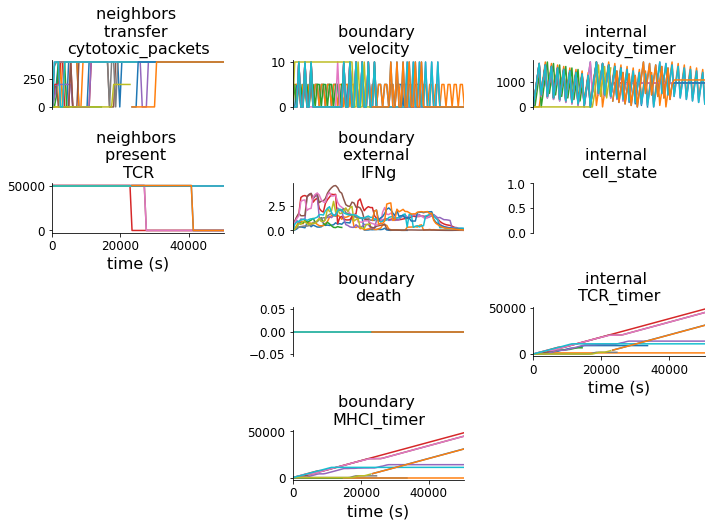

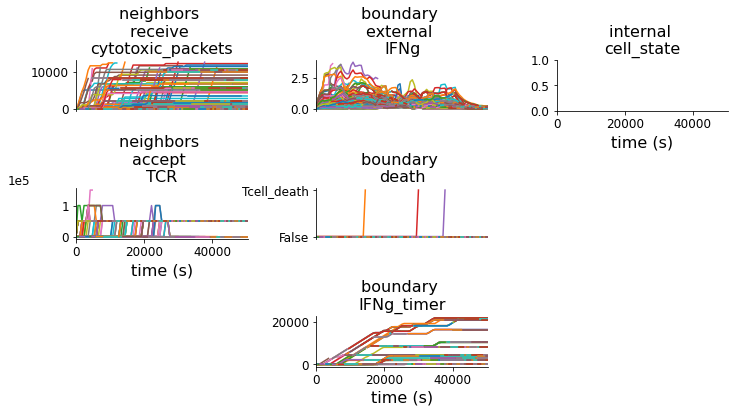

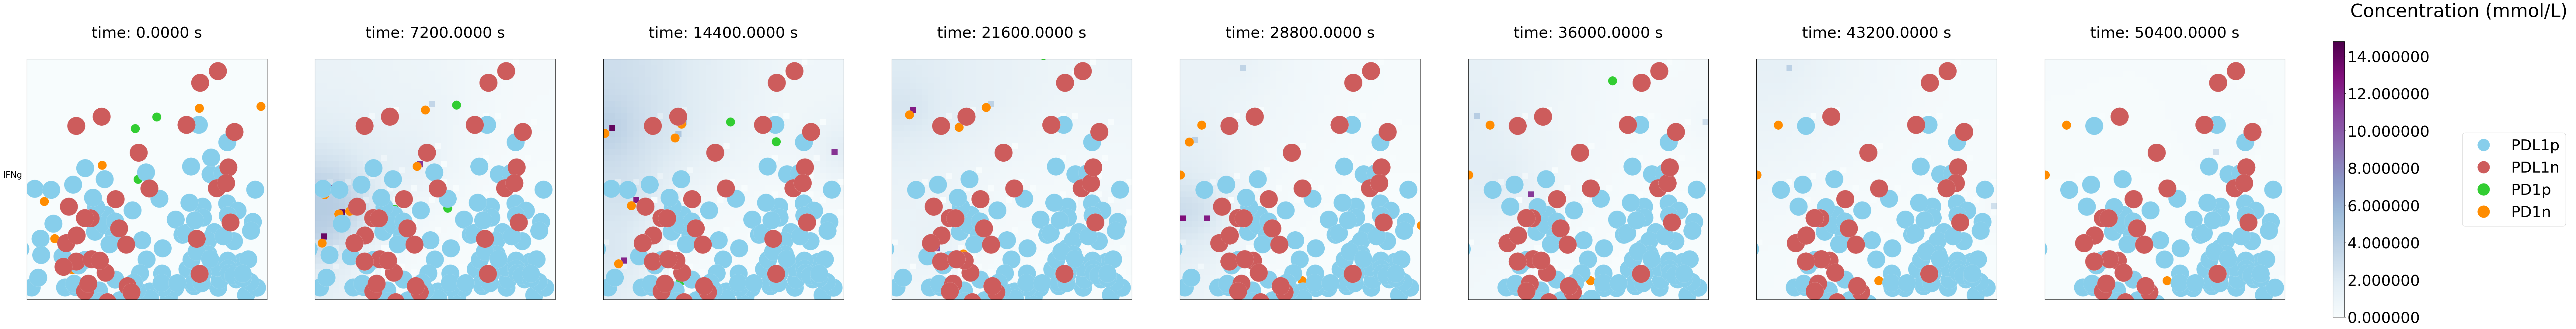

In [11]:
#Plot the data using tumor-tcell experiment notebook and save in current directory
fig1, fig2, fig3 = plots_suite(data, out_dir = os.getcwd(), bounds=[b*units.um for b in bounds])

#Convert ABM data output to pandas dataframe format

In [ ]:
#Convert to initial dataframe
df_data = pd.DataFrame(data)


#Extract agents from the data
df_copy = df_data.copy()
df_agents = df_copy.iloc[0,:]
agents_dict = df_agents.to_dict()

#reformat the dictionary into mulitiindexed dataframe
reform_agents = {(level1_key, level2_key): values
          for level1_key, level2_dict in agents_dict.items()
          for level2_key, values in level2_dict.items()
          }
df_agents_exp1 = pd.DataFrame(reform_agents)
df_agents_multi = df_agents_exp1.T
names=['time', 'cell']
df_agents_multi.index.set_names(names, inplace=True)


#Subset only T cells from all agents
df_tcell_agents = df_agents_multi.iloc[df_agents_multi.index.get_level_values('cell').str.contains('tcell'), :]


#Subset categories and recombine in T cells
df_tcell_trans = df_tcell_agents.T
tcell_categories = []

#Extract each feature - boundary, internal, neighbors
for category in df_tcell_trans.index.values:
  df_boundary_sub = df_tcell_trans.loc[category,:]
  tcell_boundary_dict = df_boundary_sub.to_dict()
  df_boundary_sub2 = pd.DataFrame(tcell_boundary_dict)
  tcell_categories.append(df_boundary_sub2.T)

#concatenate dataframes
tcell_data = pd.concat(tcell_categories, axis=1)


#reformat T cell data for plotting
tcell_data['IFNg'] = tcell_data['external'].apply(lambda x: x.get('IFNg'))
#tcell_data['PD1'] = tcell_data['present'].apply(lambda x: x.get('PD1'))
#tcell_data['PDL1'] = tcell_data['accept'].apply(lambda x: x.get('PDL1'))
#tcell_data['MHCI'] = tcell_data['accept'].apply(lambda x: x.get('MHCI'))
tcell_data['transferable_cytotoxic_packets'] = tcell_data['transfer'].apply(lambda x: x.get('cytotoxic_packets'))
tcell_data['X'] = tcell_data['location'].apply(lambda x: x[0])
tcell_data['Y'] = tcell_data['location'].apply(lambda x: x[1])
tcell_data['MHCI_timer'] = tcell_data['MHCI_timer'].astype(float)
#tcell_data['total_cytotoxic_packets'] = tcell_data['total_cytotoxic_packets'].astype(float)

#Only select columns of interest
tcell_columns = ['MHCI_timer', 'cell_state', 'death',
                 'IFNg', 'transferable_cytotoxic_packets', 'X', 'Y']
tcell_data_form = tcell_data[tcell_columns]
tcell_data_form.index.set_names(names, inplace=True)

#Get different death groupings and count total over time
death_types_list = list(tcell_data_form['death'].unique())
death_types_list.remove(False)
for death_type in death_types_list:
  tcell_data_form[death_type] = tcell_data_form['death'].apply(lambda x: 1 if x==death_type else 0)
  tcell_data_form['total_'+str(death_type)] = tcell_data_form[death_type].cumsum()

tcell_data_form

In [ ]:
#Subset only Tumor cells from all agents
df_tumor_agents = df_agents_multi.iloc[df_agents_multi.index.get_level_values('cell').str.contains('tumor'), :]


#Subset categories and recombine in Tumor cells
df_tumor_trans = df_tumor_agents.T
tumor_categories = []

#Extract each feature - boundary, internal, neighbors
for category in df_tumor_trans.index.values:
  df_boundary_sub = df_tumor_trans.loc[category,:]
  tumor_boundary_dict = df_boundary_sub.to_dict()
  df_boundary_sub2 = pd.DataFrame(tumor_boundary_dict)
  tumor_categories.append(df_boundary_sub2.T)

#concatenate dataframes
tumor_data = pd.concat(tumor_categories, axis=1)
tumor_data;

#reformat Tumor cell data for plotting
tumor_data['IFNg'] = tumor_data['external'].apply(lambda x: x.get('IFNg'))
#tumor_data['PD1'] = tumor_data['accept'].apply(lambda x: x.get('PD1'))
#tumor_data['PDL1'] = tumor_data['present'].apply(lambda x: x.get('PDL1'))
#tumor_data['MHCI'] = tumor_data['present'].apply(lambda x: x.get('MHCI'))
tumor_data['cytotoxic_packets'] = tumor_data['receive'].apply(lambda x: x.get('cytotoxic_packets'))
tumor_data['X'] = tumor_data['location'].apply(lambda x: x[0])
tumor_data['Y'] = tumor_data['location'].apply(lambda x: x[1])
tumor_data['IFNg_timer'] = tumor_data['IFNg_timer'].astype(float)
tumor_data.columns

#Only select columns of interest
tumor_columns = ['IFNg_timer', 'death', 'cell_state', 'IFNg', 'cytotoxic_packets', 'X', 'Y']
tumor_data_form = tumor_data[tumor_columns]
tumor_data_form.index.set_names(names, inplace=True)

#Get different death groupings and count total over time
tumor_death_types_list = list(tumor_data_form['death'].unique())
tumor_death_types_list.remove(False)
for death_type in tumor_death_types_list:
  tumor_data_form[death_type] = tumor_data_form['death'].apply(lambda x: 1 if x==death_type else 0)
  tumor_data_form['total_'+str(death_type)] = tumor_data_form[death_type].cumsum()

tumor_data_form

In [ ]:
#phylogeny plot?

#Plotting the Data from the Experiment

In [ ]:
#reset index for plotting
tcell_plot = tcell_data_form.reset_index()
death_types_list_total = ['total_'+ s for s in death_types_list] 
death_types_list.extend(death_types_list_total)
# plot the data to analyze
plotting_columns = ['cell', 'MHCI_timer', 'cell_state', 'IFNg', 'transferable_cytotoxic_packets']
plotting_columns.extend(death_types_list)
for column in plotting_columns:
  pl.figure(figsize=(16, 6))
  column = sns.lineplot(data=tcell_plot, x="time", y=column, style = 'cell_state', hue="cell", legend = None)

In [ ]:
#How to extract individual T cells
df_divide_T = tcell_plot.drop_duplicates('cell', keep='first')

#Get unique agent IDs
unique_T_cell = list(df_divide_T.cell.unique())

#run phylogeny function
phylogeny_T = get_phylogeny(unique_T_cell)

# get initial ancestors, daughters, and mothers
daughters_T = list(phylogeny_T.values())
daughters_T = set([item for sublist in daughters_T for item in sublist])
descendents_T = list(daughters_T)
mothers_T = set(list(phylogeny_T.keys()))
ancestors_T = list(mothers_T - daughters_T)
ancestors_T;

In [ ]:
#Time for plotting cell divisions
div_list_T = []
for cell in descendents_T:
  div = df_divide_T[df_divide_T["cell"] == cell]['time'].min()
  div_list_T.append(div)

#get unique counts from the list
div_counts_T = Counter(div_list_T)
divide_time_T = pd.DataFrame.from_dict(div_counts_T, orient='index').reset_index()

#convert to dataframe
column_names = ['time', 'counts']
divide_time_T.columns = column_names

#divide counts by 2 because each daughter and original cell is counted twice
divide_time_T['counts'] = divide_time_T['counts'] / 2

#add 0, 0 initial point
divide_time_T.loc[-1] = [0, 0]
divide_time_T.index = divide_time_T.index + 1  # shifting index
divide_time_T = divide_time_T.sort_values(by = 'time') 

#accumulate the counts as progresses
divide_time_T['total_division'] = divide_time_T.counts.cumsum()

pl.figure(figsize=(16, 6))
div_cell_T = sns.lineplot(data=divide_time_T, x="time", y='total_division')

pl.title("# of divisions")

In [ ]:
#Plot total cells and see how changing over time
total_tcell = tcell_plot.groupby('time')['cell'].nunique().reset_index()
tcell_state = tcell_plot.groupby(['time','cell_state'])['cell'].nunique().reset_index()
total_PD1n = tcell_state.loc[tcell_state['cell_state']=='PD1n']
total_PD1p = tcell_state.loc[tcell_state['cell_state']=='PD1p']

pl.figure(figsize=(16, 6))
ttl_tcell = sns.lineplot(data=total_tcell, x="time", y='cell', label = 'total')
ttl_PD1n = sns.lineplot(data=total_PD1n, x="time", y='cell', label = 'PD1n')
ttl_PD1p = sns.lineplot(data=total_PD1p, x="time", y='cell', label = 'PD1p')

pl.title("Total T Cells")
pl.legend(title="Cell type")

In [ ]:
#Spatial
pl.figure(figsize=(10, 10))
XandY = sns.lineplot(data=tcell_plot, x="X", y="Y", style = 'cell_state', hue="cell", legend = None)

In [ ]:
#reset index for plotting
tumor_plot = tumor_data_form.reset_index()
tumor_death_types_list_total = ['total_'+ s for s in tumor_death_types_list] 
tumor_death_types_list.extend(tumor_death_types_list_total)

# plot the data to analyze
plotting_columns = ['cell', 'IFNg_timer', 'cell_state', 'IFNg', 'cytotoxic_packets']
plotting_columns.extend(tumor_death_types_list)
for column in plotting_columns:
  pl.figure(figsize=(16, 6))
  column = sns.lineplot(data=tumor_plot, x="time", y=column, style = 'cell_state', hue="cell", legend = None)

In [ ]:
#How to extract individual tumor cells
df_divide_tumor = tumor_plot.drop_duplicates('cell', keep='first')

#Get unique agent IDs
unique_tumor_cell = list(df_divide_tumor.cell.unique())

#run phylogeny function
phylogeny_tumor = get_phylogeny(unique_tumor_cell)

# get initial ancestors, daughters, and mothers
daughters_tumor = list(phylogeny_tumor.values())
daughters_tumor = set([item for sublist in daughters_tumor for item in sublist])
descendents_tumor = list(daughters_tumor)
mothers_tumor = set(list(phylogeny_tumor.keys()))
ancestors_tumor = list(mothers_tumor - daughters_tumor)
descendents_tumor;

In [ ]:
#Time for plotting cell divisions
div_list_tumor = []
for cell in descendents_tumor:
  div = df_divide_tumor[df_divide_tumor["cell"] == cell]['time'].min()
  div_list_tumor.append(div)

#get unique counts from the list
div_counts_tumor = Counter(div_list_tumor)
divide_time_tumor = pd.DataFrame.from_dict(div_counts_tumor, orient='index').reset_index()

#convert to dataframe
column_names = ['time', 'counts']
divide_time_tumor.columns = column_names

#divide counts by 2 because each daughter and original cell is counted twice
divide_time_tumor['counts'] = divide_time_tumor['counts'] / 2

#add 0, 0 initial point
divide_time_tumor.loc[-1] = [0, 0]
divide_time_tumor.index = divide_time_tumor.index + 1  # shifting index
divide_time_tumor = divide_time_tumor.sort_values(by = 'time') 

#accumulate the counts as progresses
divide_time_tumor['total_division'] = divide_time_tumor.counts.cumsum()

pl.figure(figsize=(16, 6))
div_cell_tumor = sns.lineplot(data=divide_time_tumor, x="time", y='total_division')

pl.title("# of divisions")

In [ ]:
#Plot total cells and see how changing over time
total_tumor = tumor_plot.groupby('time')['cell'].nunique().reset_index()
tumor_state = tumor_plot.groupby(['time','cell_state'])['cell'].nunique().reset_index()
total_PDL1n = tumor_state.loc[tumor_state['cell_state']=='PDL1n']
total_PDL1p = tumor_state.loc[tumor_state['cell_state']=='PDL1p']

pl.figure(figsize=(16, 6))
ttl_tumorcell = sns.lineplot(data=total_tumor, x="time", y='cell', label = 'total')
ttl_PDL1n = sns.lineplot(data=total_PDL1n, x="time", y='cell', label = 'PDL1n')
ttl_PDL1p = sns.lineplot(data=total_PDL1p, x="time", y='cell', label = 'PDL1p')

pl.title("Total Tumor Cells")
pl.legend(title="Cell type")

#Spatial Widget

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

def plot_func(time):
    x = tcell_plot[tcell_plot['time']<=time]['X']
    y = tcell_plot[tcell_plot['time']<=time]['Y']
    data_t = tcell_plot[tcell_plot['time']<=time]
    xandy = sns.lineplot(data=data_t, x=x, y=y, hue = 'cell_state', style = 'cell', legend = None)
    pl.show()

interact(plot_func, time = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=10000,
                                               step=60))

In [ ]:
tcell_plot.X.min()

In [ ]:
tcell_plot.Y.min()

In [ ]:
#tcell_plot.to_csv(ROOT + '/My Drive/Research/TNT/ABM_CODEX/Scripts_Data/'+'tcell_neg_data.csv')